In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits import mplot3d
import random
import itertools
%matplotlib inline

In [132]:
import sklearn.model_selection as ModelSelection
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_confusion_matrix, precision_score, f1_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from matplotlib.colors import Normalize
from sklearn.naive_bayes import GaussianNB

In [3]:
# Data acquired from https://yle.fi/uutiset/3-10725384
# Contains YLE election compass data for parlamentary elections 2019

In [4]:
df = pd.read_csv('Avoin_data_eduskuntavaalit_2019_valintatiedot.csv', delimiter=',')

In [5]:
X = df.loc[:, 'Suomen pitää olla edelläkävijä ilmastonmuutoksen vastaisessa taistelussa, vaikka se aiheuttaisi suomalaisille kustannuksia.':'On oikein nähdä vaivaa sen eteen, ettei vahingossakaan loukkaa toista.'].replace('-', np.nan).astype('category')

In [116]:
X.shape

(2437, 29)

In [6]:
y = df.puolue

In [7]:
X_train, X_test, y_train, y_test = ModelSelection.train_test_split(X, y, test_size=.2, random_state=42)

In [131]:
y_test.shape

(488,)

In [152]:
nb_pipe = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('nb', GaussianNB())
])

nb_pred = nb_pipe.fit(X_train, y_train)
cross_val_score(nb_pred, X_train, y_train, cv=5)
#print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test != y_pred).sum()))

/Users/santerivaataja/Desktop/Vaalidata.nosync/vaali_venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


array([0.45384615, 0.48717949, 0.47948718, 0.44615385, 0.50385604])

In [145]:
pipe_svc = Pipeline([
    # Yeah not too smart way to handle missing data at this instance but has to do for now
    ('imp', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
    ('scaler', StandardScaler()), 
    ('pca', PCA()), 
    ('svc', SVC())])

In [146]:
param_grid = {
    'svc__gamma':[1e-05, 1e-04, 1e-03],
    'svc__C': [237, 238, 239],
    'pca__n_components':[26, 25, 24]
    }
gs_svc = GridSearchCV(pipe_svc, param_grid=param_grid, cv=5, scoring='f1_micro')

In [147]:
gs_svc.fit(X_train, y_train)

/Users/santerivaataja/Desktop/Vaalidata.nosync/vaali_venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imp',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()), ('svc', SVC())]),
             param_grid={'pca__n_components': [26, 25, 24],
                         'svc__C': [237, 238, 239],
                         'svc__gamma': [1e-05, 0.0001, 0.001]},
             scoring='f1_micro')

In [123]:
score_train = cross_val_score(gs_svc, X_train, y_train, cv=5)
score_test = cross_val_score(gs_svc, X_test, y_test, cv=5)

/Users/santerivaataja/Desktop/Vaalidata.nosync/vaali_venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/santerivaataja/Desktop/Vaalidata.nosync/vaali_venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/santerivaataja/Desktop/Vaalidata.nosync/vaali_venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/santerivaataja/Desktop/Vaalidata.nosync/vaali_venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least popula

In [127]:
print([round(i, 4) for i in score_train])
print([round(i, 4) for i in score_test])

[0.5513, 0.559, 0.5821, 0.5692, 0.563]
[0.4898, 0.5306, 0.551, 0.5361, 0.5052]


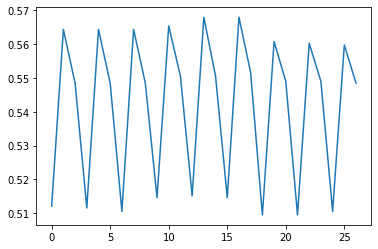

In [18]:
mean_score = gs_svc.cv_results_['mean_test_score']
plt.plot(np.arange(len(mean_score)) , gs_svc.cv_results_['mean_test_score'])

In [106]:
par_score = dict(zip(zip(gs_svc.cv_results_['param_pca__n_components'], gs_svc.cv_results_['param_svc__C'], gs_svc.cv_results_['param_svc__gamma']), gs_svc.cv_results_['mean_test_score']))
#plt.plot(list(par_score.keys())[])

legends = []
x = np.arange(1, 4)
for i in gs_svc.cv_results_['param_pca__n_components']:
    legends.append(list(filter(lambda x: (x[0] == i), list(par_score.keys()))))
        #plt.plot(x, par_score[legends[-1]], c=random.randint(1,100))
#plt.show()

In [151]:
print(f"For training data: \n\tScore: {gs_svc.best_score_} with values {gs_svc.best_params_}")

For training data: 
	Score: 0.558222925318041 with values {'pca__n_components': 25, 'svc__C': 237, 'svc__gamma': 0.0001}


For training data: 
	Score: 0.5679770614989124 with values {'pca__n_components': 25, 'svc__C': 240, 'svc__gamma': 0.0001}

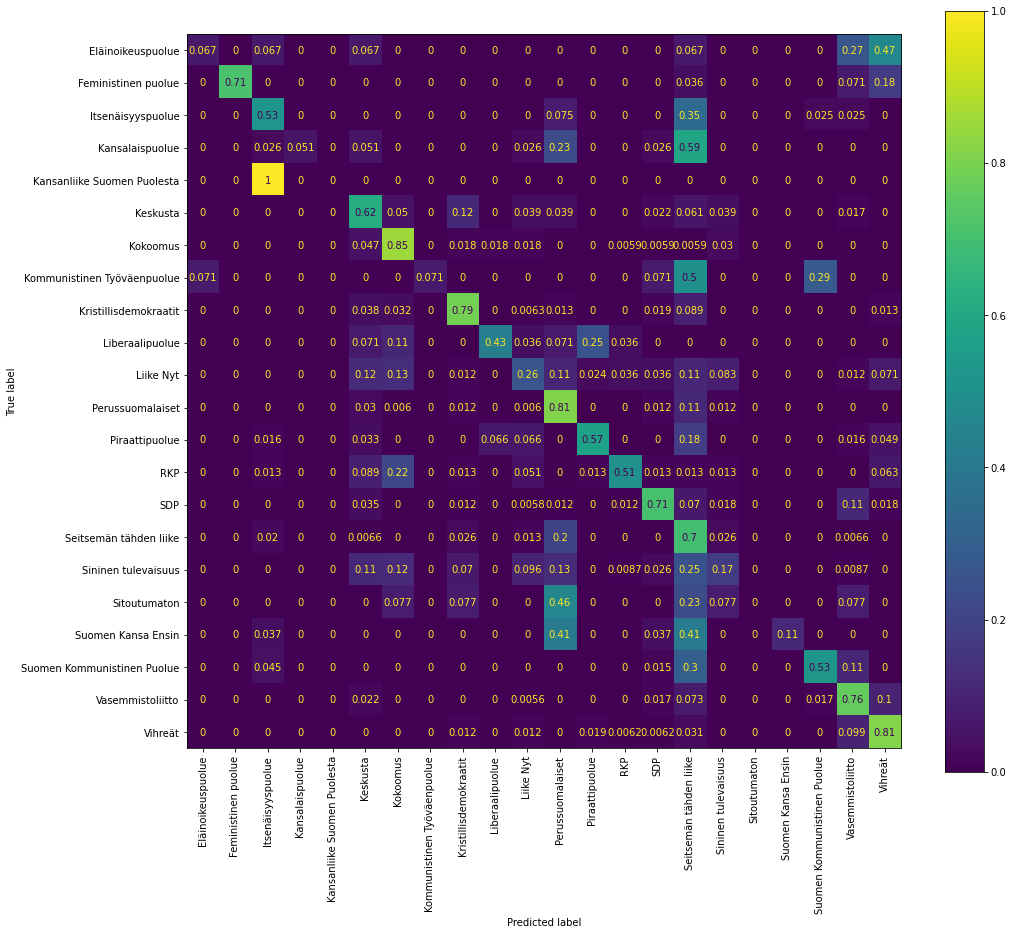

In [153]:
fig, ax = plt.subplots(figsize=(16,14))
plot_confusion_matrix(gs_svc, X_train, y_train, normalize='true', xticks_rotation='vertical', ax=ax)
plt.savefig('confusion.png')

In [129]:
test_pred = gs_svc.best_estimator_.predict(X_test)

In [130]:
acc = precision_score(y_test, test_pred, average='micro')
print(f"Accuracy with test data: {acc} with values {gs_svc.best_params_}")

Accuracy with test data: 0.555327868852459 with values {'pca__n_components': 25, 'svc__C': 238, 'svc__gamma': 0.0001}


For testing data: Score: 0.5532786885245902 with values {'pcan_components': 25, 'svcC': 240, 'svc__gamma': 0.0001}

In [14]:
# This code is copied from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],3),       # rounding added
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


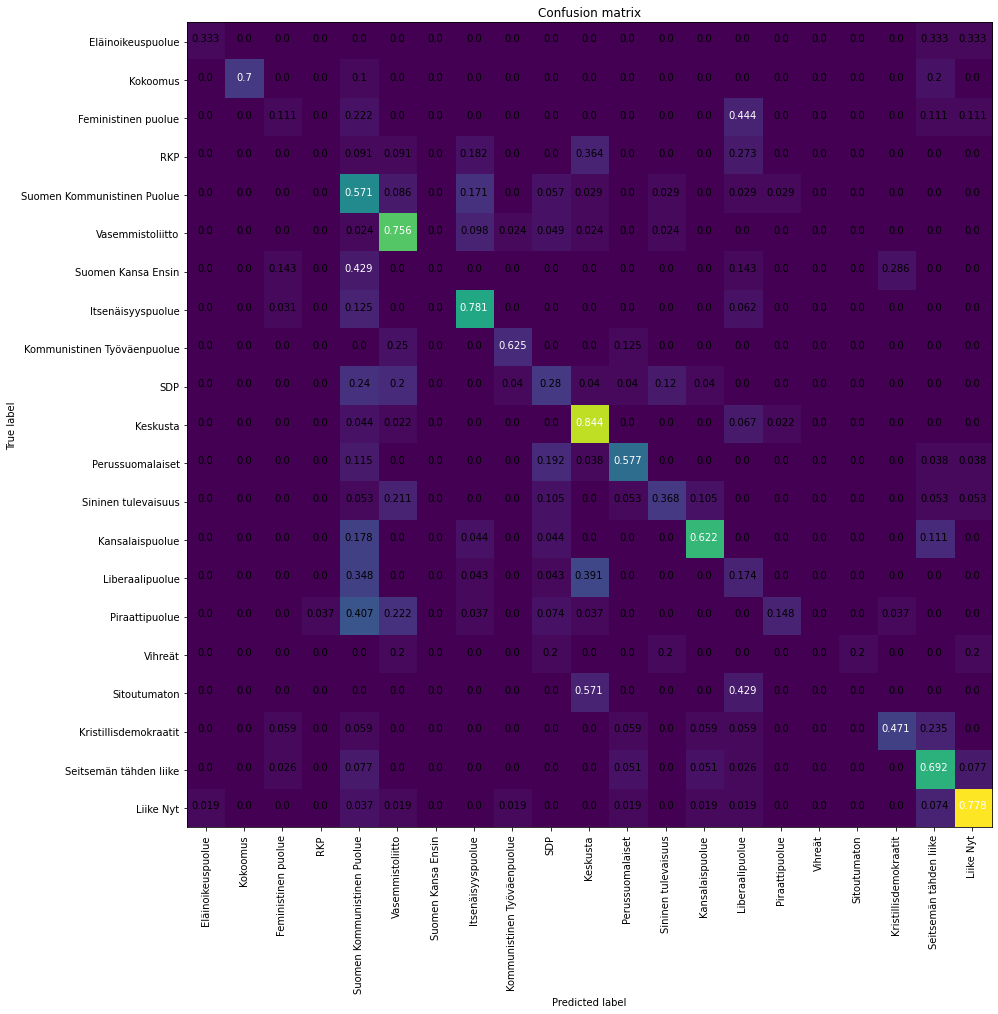

In [15]:
plt.figure(figsize=(16,14))
cm = confusion_matrix(y_true=y_test, y_pred=test_pred)
plot_confusion_matrix(cm, classes=set(y_test), normalize=True, cmap=plt.cm.viridis)
plt.show()

In [16]:
pca_scatter_3 = PCA(n_components=3)
X_test_mean = SimpleImputer(missing_values=np.nan, strategy='mean').fit(X_test)
pca_scatter_3.fit(X_test_mean.transform(X_test))

PCA(n_components=3)

<ipython-input-17-14e49525c70b>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


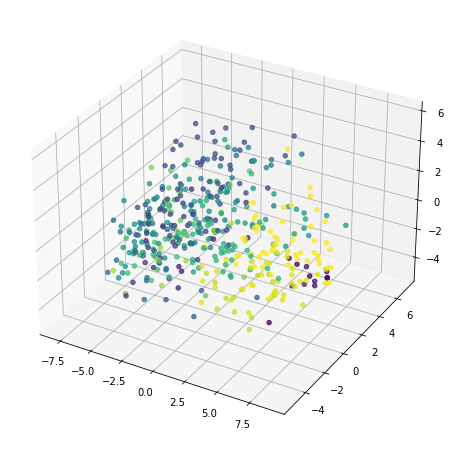

In [17]:
d3 = pca_scatter_3.transform(X_test_mean.transform(X_test))
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
sc = ax.scatter3D(d3[:, 0], d3[:, 1], d3[:, 2], c=y_test.astype('category').cat.codes, alpha=.75)
fig.show()

In [18]:
pca_scatter_2 = PCA(n_components=2)
pca_scatter_2.fit(X_test_mean.transform(X_test))

PCA(n_components=2)

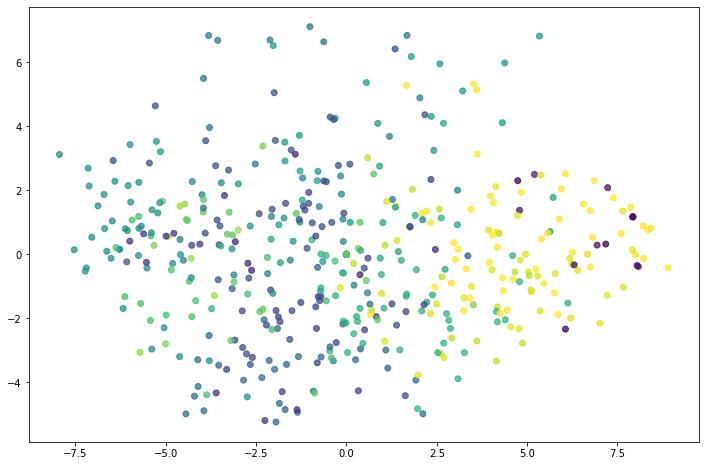

In [19]:
d2 = pca_scatter_2.transform(X_test_mean.transform(X_test))
plt.figure(figsize=(12,8))
plt.scatter(d2[:, 0], d2[:, 1], c=y_test.astype('category').cat.codes, alpha=.75)

# KMeans

In [23]:
pipe_km = Pipeline([
    # Yeah not too smart way to handle missing data at this instance but has to do for now
    ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')), 
    ('scaler', StandardScaler()), 
    ('pca', PCA()), 
    ('km', KMeans(n_clusters=21))])

In [24]:
param_grid = {
    'km__tol': [1e-4,1e-5,1e-6],
    'km__n_init': [5,10,15,20],
    'pca__n_components':[26, 25, 24]
    }
gs_km = GridSearchCV(pipe_km, param_grid=param_grid, cv=5, scoring='f1_micro')

In [25]:
gs_km.fit(X_train)

on for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/santerivaataja/Desktop/Vaalidata.nosync/vaali_venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 672, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/santerivaataja/Desktop/Vaalidata.nosync/vaali_venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/santerivaataja/Desktop/Vaalidata.nosync/vaali_venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 672, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/santerivaataja/Desktop/Vaalidata.nosync/vaali_venv/lib

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imp', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('km', KMeans(n_clusters=21))]),
             param_grid={'km__n_init': [5, 10, 15, 20],
                         'km__tol': [0.0001, 1e-05, 1e-06],
                         'pca__n_components': [26, 25, 24]},
             scoring='f1_micro')